# Indirect solution of Dyson equation - without inversion

The electronic self-energy is obtained by solving the Dyson equation

$$ \Sigma(i\omega_{n}) = G_{0}^{-1}(i\omega_{n}) - G^{-1}(i\omega_{n}),$$
where $G_{0}(i\omega_{n})$ is the Weiss field and $G(i\omega_{n})$ is the full interacting Green's function.

The proposed scheme solves this equation indirectly by minimizing the residual,
$$ \mathrm{min}_{\Sigma(i\omega_{n})}\quad||G(i\omega_{n}) - G_{0}(i\omega_{n}) - G_{0}(i\omega_{n})\Sigma(i\omega_{n})G(i\omega_{n})||,$$
where inversion is not required. This avoids the numerical instability innate to the first equation. We have achieve this by using the discrete Lehmann representation (DLR) to represent all quantities and optimize the set of DLR coefficients that satisfy the high-frequency constraint on the self-energy

$$ \Sigma(i\omega_{n}\rightarrow\infty) = \Sigma_{\infty} + \frac{\Sigma_{1}}{i\omega_{n}} + \mathcal{O}(\omega_{n}^{-2})$$

The minimization algorithm is implemented as follows. The main inputs to the minimization routine are: $G_{0}(i\omega_{n})$, $G(i\omega_{n})$, and $\{ \Sigma_{\infty}, \Sigma_{1} \}$.

  1. Obtain DLR for G(tau) and G0(tau)
  2. Compute Sigma(iw) from G(iw) and G0(iw) obtained from DLRs.

In [1]:
from pydlr import kernel, dlr
from triqs.gf import *
from h5 import HDFArchive
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

import matplotlib.pyplot as plt
plt.style.use('publish')

from dimer import *
from common import *

Starting serial run at: 2023-02-10 17:19:04.179262


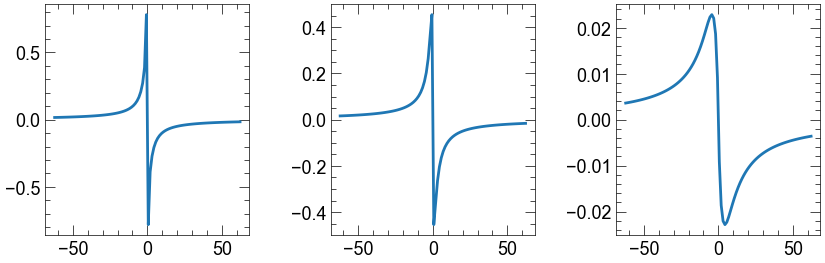

In [2]:
iwn = np.array([complex(x) for x in Sigma_iw_ref.mesh])
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].plot(iwn.imag, G0_iw['up'].data[:,0,0].imag)
ax[1].plot(iwn.imag, G_iw_ref['up'].data[:,0,0].imag)
ax[2].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag)
plt.subplots_adjust(wspace=0.4)

In [3]:
class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs

In [29]:
def constrained_lstsq_dlr_from_tau(d,         # dlr class
                                   tau_i,     # tau mesh
                                   beta,      # inverse temperature
                                   g_iaa,     # G data
                                   g0_iaa,    # G0 data
                                   sigma_moments, # high-freq moments of Σ
                                   ftol=1e-8, 
                                   symmetrizer=None):
    
    
    
    
    
    nx = len(d)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    dtype = complex
    nX = nx * (no + 2*N)
    
    # fold and unfold complex numbers
    
    def merge_re_im(x):
        x_d, x_u = x[:nx*no], x[nx*no:]
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        return x_d, x_u

    def split_re_im(x_d, x_u):
        return np.concatenate((
            np.array(x_d.real, dtype=float),
            np.array(x_u.real, dtype=float),
            np.array(x_u.imag, dtype=float)))
                                   
    # Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x
    
    
    # constraint
    sig_infty, sigma_1 = sigma_moments[0], sigma_moments[1]
        
    def mat_vec(mat):
        v_d = sym.get_x_d(mat[None, ...]).real
        v_u = sym.get_x_u(mat[None, ...])
        v = split_re_im(v_d, v_u)
        return v
        
    def constraint_func(x):
        sig = g_from_x(x)
        mat = -sig.sum(axis=0)
        vec = mat_vec(mat)
        return vec
    
    bound = mat_vec(sigma_1)
    
    constraints = (NonlinearConstraint(constraint_func,
                                           bound, bound))


    # target function
    def dyson_difference(x_sig):
        sig_xaa = g_from_x(x_sig)
        
        # evaulate G, G0, Sigma
        #g_waa = d.eval_dlr_freq(g_xaa, iw_i, beta)
        #g0_waa = d.eval_dlr_freq(g0_xaa, iw_i, beta)
        #sig_waa = d.eval_dlr_freq(sig_xaa, freq, beta) + sig_infty
        sig_waa = d.matsubara_from_dlr(sig_xaa, beta)+sig_infty
        #  G - G0 - G0*Σ*G = 0
        # done on DLR nodes of iw
        err_waa = g_waa - g0_waa - g0_waa[:,...]@sig_waa[:,...]@g_waa[:,...]
        
        # Res(iw) = G(iw) - G0(iw) - G0(iw)Σ(iw)G(iw)
        # compute DLR of Res(iw)
        # Res(tau)
        return err_waa.flatten()
        
    def target_function(x_sig):
        y = dyson_difference(x_sig)
        return np.linalg.norm(y) 
    
    # initial dlr fit to G and G0
    g_xaa = d.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
    g0_xaa = d.lstsq_dlr_from_tau(tau_i, g0_iaa, beta)
    
    g_waa = d.matsubara_from_dlr(g_xaa, beta)
    g0_waa = d.matsubara_from_dlr(g0_xaa, beta)
    
    # better first guess?
    #sig_init_xaa = np.empty_like(g_init_xaa)
    freq = d.get_matsubara_frequencies(beta)
    
    sig_init_xaa = d.lstsq_dlr_from_matsubara(freq, np.linalg.inv(g0_waa[:,...])-
                                                                 np.linalg.inv(g_waa[:,...])-sig_infty,
                                              beta)

    #x_init  = x_from_g(g_init_xaa)         # DLR coeffs of G(tau)
    #x0_init = x_from_g(g0_init_xaa)        # DLR coeffs of G0(tau
    x_sig = x_from_g(sig_init_xaa)      # DLR coeffs of Σ(iwn)-Σoo.

    # minimize
    sol = minimize(target_function, x_sig,
        method='SLSQP', 
        constraints=constraints,
        options=dict(ftol=ftol, maxiter=10000, disp=True),
        )
    print(sol.success, sol.message)
    
    sig_xaa = g_from_x(sol.x)
    print(f'Σ1 constraint diff: {np.max(np.abs(-sig_xaa.sum(axis=0)-sigma_1)):.4e}')

    return sig_xaa, sol

In [30]:
def fit_dlr(d, G_tau, G0_tau, Sigma_moments, ftol=1e-9):
    
    tau = np.array([float(x) for x in G_tau.mesh])
    
    beta = G_tau.mesh.beta
    sig_xaa = {}
 
    for block, gf in G_tau:
        
        sig_xaa[block], sol = constrained_lstsq_dlr_from_tau(d, tau, beta,
                                                         G_tau[block].data, 
                                                         G0_tau[block].data,
                                                         Sigma_moments[block],
                                                         ftol=ftol,
                                                        )
    return sig_xaa

In [31]:
sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)

In [32]:
d = dlr(lamb=30,eps=1e-9)
G0_tau = make_gf_from_fourier(G0_iw)
tau_i = np.array([x.real for x in G0_tau.mesh])
iw_i  = np.array([complex(x) for x in Sigma_iw_ref.mesh])
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i, 
                                   beta,
                                   G_tau_ref['up'].data,
                                   G0_tau['up'].data,
                                   sigma_moments['up'],
                                   ftol=1e-9, 
                                   symmetrizer=None)
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta) +sigma_moments['up'][0]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.645141158052624e-06
            Iterations: 35
            Function evaluations: 2658
            Gradient evaluations: 35
True Optimization terminated successfully
Σ1 constraint diff: 1.5608e-06


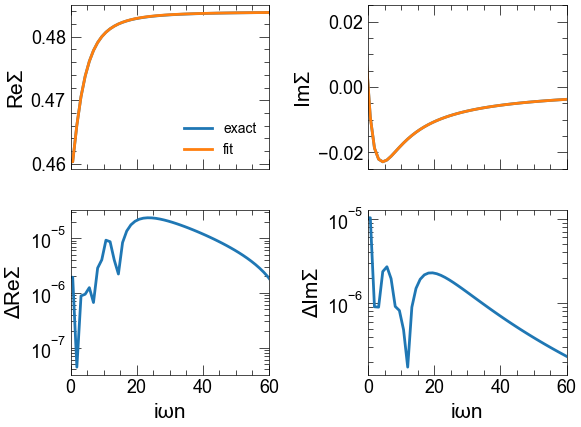

In [33]:
fig, ax = plt.subplots(2,2,sharex=True,)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[0,0].set_ylabel('ReΣ')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[1,0].set_ylabel('ΔReΣ')
ax[1,0].set_xlabel('iωn')
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[0,1].set_ylabel('ImΣ')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[1,1].set_ylabel('ΔImΣ')
ax[1,1].set_xlabel('iωn')
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.show()

In [34]:
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
for block, _ in G_tau_qmc: G_tau_qmc[block].data[:] += np.random.normal(scale=tol, size=G_tau_qmc[block].data.shape)
Sigma_iw_qmc = inverse(G0_iw) - inverse(make_gf_from_fourier(G_tau_qmc))
d = dlr(lamb=30,eps=1e-6)

In [35]:
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i,
                                   beta, 
                                   G_tau_qmc['up'].data,
                                   G0_tau['up'].data,
                                   sigma_moments['up'],
                                   ftol=1e-9, 
                                   symmetrizer=None)
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta)+sigma_moments['up'][0]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00012139802884774625
            Iterations: 81
            Function evaluations: 4340
            Gradient evaluations: 81
True Optimization terminated successfully
Σ1 constraint diff: 1.5608e-06


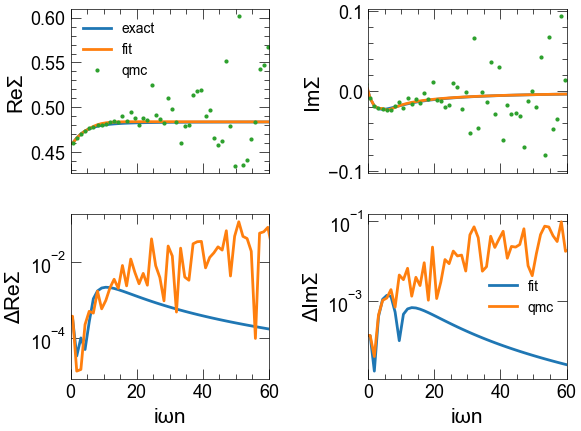

In [36]:
fig, ax = plt.subplots(2,2,sharex=True,)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[0,0].plot(iwn.imag, Sigma_iw_qmc['up'].data[:,0,0].real, 'o', label='qmc',ms=2)
ax[0,0].set_ylabel('ReΣ')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real), label='fit',)
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_qmc['up'].data[:,0,0].real), label='qmc')
ax[1,0].set_ylabel('ΔReΣ')
ax[1,0].set_xlabel('iωn')
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[0,1].plot(iwn.imag, Sigma_iw_qmc['up'].data[:,0,0].imag, 'o', label='qmc',ms=2)
ax[0,1].set_ylabel('ImΣ')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag),label='fit')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_qmc['up'].data[:,0,0].imag), label='qmc')
ax[1,1].set_ylabel('ΔImΣ')
ax[1,1].set_xlabel('iωn')
ax[1,1].legend()
ax[0,0].set_xlim(0,60)
plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.show()

In [37]:
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
for block, gf in G_tau_qmc: G_tau_qmc[block].data[:] += np.random.normal(scale=tol, size=G_tau_qmc[block].data.shape)
Sigma_iw_qmc = inverse(G0_iw) - inverse(make_gf_from_fourier(G_tau_qmc))
d = dlr(lamb=20,eps=1e-6)
sig_xaa = fit_dlr(d, G_tau_qmc, G0_tau, sigma_moments)
Sigma_iw_fit = Sigma_iw_ref.copy()
for block, sig in Sigma_iw_fit: Sigma_iw_fit[block].data[:] = d.eval_dlr_freq(sig_xaa[block], iw_i, beta)+sigma_moments[block][0]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00013116299498511116
            Iterations: 102
            Function evaluations: 5038
            Gradient evaluations: 102
True Optimization terminated successfully
Σ1 constraint diff: 1.5608e-06
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.301131707949972e-05
            Iterations: 74
            Function evaluations: 3673
            Gradient evaluations: 74
True Optimization terminated successfully
Σ1 constraint diff: 2.1210e-06


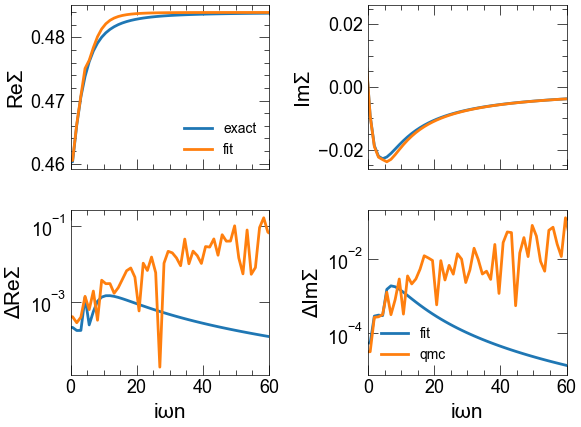

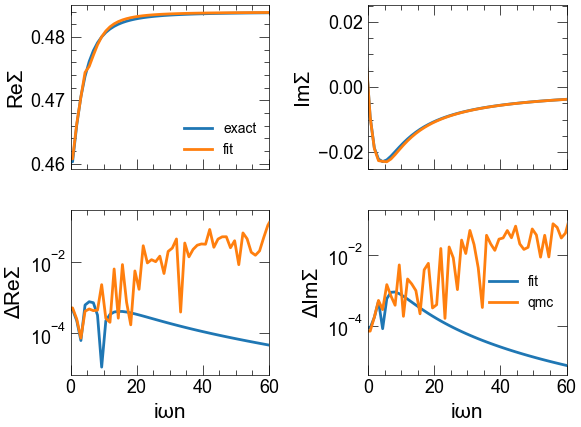

In [38]:
for block, sig in Sigma_iw_fit:
    fig, ax = plt.subplots(2,2,sharex=True,)
    ax[0,0].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].real, label='exact')
    ax[0,0].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].real, label='fit')
    #ax[0,0].plot(iwn.imag, Sigma_iw_qmc[block].data[:,0,0].real, 'o', label='qmc',ms=2)
    ax[0,0].set_ylabel('ReΣ')
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_fit[block].data[:,0,0].real))
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_qmc[block].data[:,0,0].real))
    ax[1,0].set_ylabel('ΔReΣ')
    ax[1,0].set_xlabel('iωn')
    ax[0,0].legend()
    ax[0,1].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].imag, label='exact')
    ax[0,1].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].imag, label='fit')
    #ax[0,1].plot(iwn.imag, Sigma_iw_qmc[block].data[:,0,0].imag, 'o', label='qmc',ms=2)
    ax[0,1].set_ylabel('ImΣ')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_fit[block].data[:,0,0].imag), label='fit')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_qmc[block].data[:,0,0].imag), label='qmc')
    ax[1,1].set_ylabel('ΔImΣ')
    ax[1,1].set_xlabel('iωn')
    ax[1,1].legend()
    ax[0,0].set_xlim(0,60)
    plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.show()

In [39]:
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
for block, gf in G_tau_qmc: G_tau_qmc[block].data[:] += np.random.normal(scale=tol, size=G_tau_qmc[block].data.shape)
d = dlr(lamb=30,eps=1e-6)
%time sig_xaa = fit_dlr(d, G_tau_qmc, G0_tau, sigma_moments)
Sigma_iw_fit = Sigma_iw_ref.copy()
for block, sig in Sigma_iw_fit: Sigma_iw_fit[block].data[:] = d.eval_dlr_freq(sig_xaa[block], iw_i, beta)+sigma_moments[block][0]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.900520862619536e-05
            Iterations: 65
            Function evaluations: 3497
            Gradient evaluations: 65
True Optimization terminated successfully
Σ1 constraint diff: 1.5608e-06
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00011386678401928539
            Iterations: 93
            Function evaluations: 4977
            Gradient evaluations: 93
True Optimization terminated successfully
Σ1 constraint diff: 2.1210e-06
CPU times: user 2.02 s, sys: 78.2 ms, total: 2.1 s
Wall time: 2.03 s


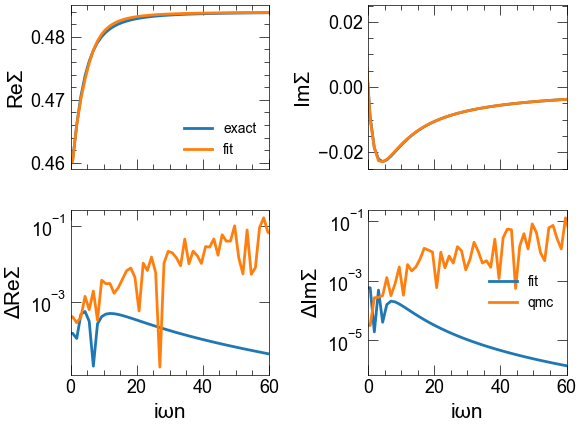

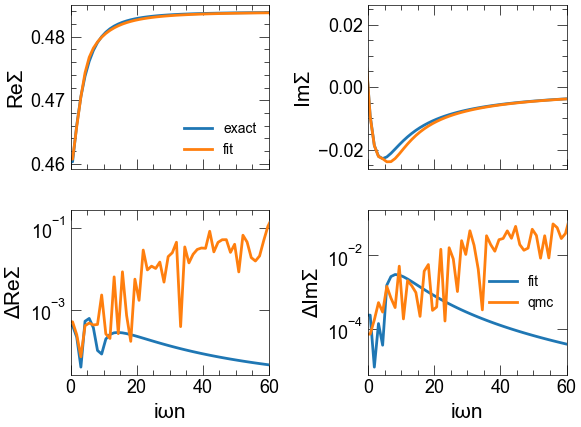

In [40]:
for block, sig in Sigma_iw_fit:
    fig, ax = plt.subplots(2,2,sharex=True,)
    ax[0,0].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].real, label='exact')
    ax[0,0].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].real, label='fit')
    #ax[0,0].plot(iwn.imag, Sigma_iw_qmc[block].data[:,0,0].real, 'o', label='qmc',ms=2)
    ax[0,0].set_ylabel('ReΣ')
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_fit[block].data[:,0,0].real))
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_qmc[block].data[:,0,0].real))
    ax[1,0].set_ylabel('ΔReΣ')
    ax[1,0].set_xlabel('iωn')
    ax[0,0].legend()
    ax[0,1].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].imag, label='exact')
    ax[0,1].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].imag, label='fit')
    #ax[0,1].plot(iwn.imag, Sigma_iw_qmc[block].data[:,0,0].imag, 'o', label='qmc',ms=2)
    ax[0,1].set_ylabel('ImΣ')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_fit[block].data[:,0,0].imag), label='fit')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_qmc[block].data[:,0,0].imag), label='qmc')
    ax[1,1].set_ylabel('ΔImΣ')
    ax[1,1].set_xlabel('iωn')
    ax[1,1].legend()
    ax[0,0].set_xlim(0,60)
    plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.show()

In [23]:
new_G_iw = inverse(inverse(G0_iw) - Sigma_iw_fit)
old_G_iw = make_gf_from_fourier(G_tau_qmc)

In [24]:
print(f"ΔG (new) = {np.max(np.abs(new_G_iw['up'].data-G_iw_ref['up'].data)):.4e}")
print(f"ΔG (old) = {np.max(np.abs(old_G_iw['up'].data-G_iw_ref['up'].data)):.4e}")

ΔG (new) = 8.9366e-05
ΔG (old) = 6.5194e-05
